## Unsupervised learning work

In [ ]:
!pip install umap-learn
!pip install -U yellowbrick
from yellowbrick.cluster.elbow import kelbow_visualizer
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.spatial.distance import cdist
from itertools import product
import matplotlib.pyplot as plt
import umap.umap_ as umap
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

     |████████████████████████████████| 80 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 16.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=3301b4de87db09c99e10ed21084fdd566e84b35d3f3b2ba71fd374cf567b091f
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=75ca61e5aae0707847f3b6bdd43ceddef01bff9b6f6411fe290f16b377a9a5c0
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent
     |████████████████████████████████| 271 kB 7.5 MB/s 
  Attempting uninstall: yellowbrick
    Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


### create dataset

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


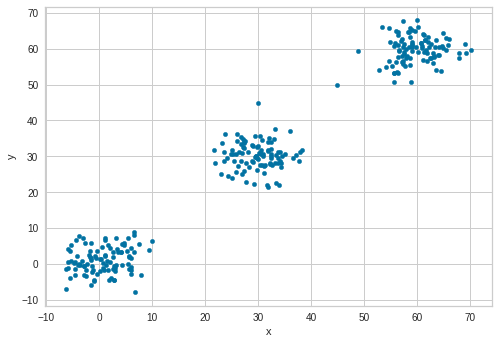

In [ ]:
def create_mixture(n_of_mixtures, mean_change=1):
    sigma = [[15, 2], [2, 15]]
    data = np.random.multivariate_normal(mean = [1, 1], cov = sigma, size = 100)
    for i in range(1, n_of_mixtures):
        aux = np.random.multivariate_normal(mean = np.dot([1, 1], i*mean_change), cov = sigma, size = 100)
        data = np.concatenate((data, aux), axis=0)
    return pd.DataFrame(data, columns = ["x", "y"])
data = create_mixture(3, mean_change=30)
data.plot.scatter(x = "x", y = "y")

### normalization, distance and split functions

In [ ]:
def normalization(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def euclidean_distance(x, y):
    return np.linalg.norm( np.subtract(x, y))

In [ ]:
def manhattan_distance(x, y):
    return sum(abs(e1-e2) for e1, e2 in zip(x,y))

In [ ]:
def mahalanobis_distance(x, y):
    xx, yy = np.array(x), np.array(y)
    e = xx-yy
    X = np.vstack([xx,yy])
    V = np.cov(X.T)
    try:
        p = np.linalg.inv(V)
    except:
        p = np.linalg.pinv(V) #just in case the produced matrix cannot be inverted
    D = np.sqrt(np.sum(np.dot(e,p) * e))
    return D

In [ ]:
def split_data(df, val = True):
    train = df.sample(frac=0.8)
    test = df.drop(train.index)
    if val == True:
        validation = train.sample(frac = 0.25) # 100*20/80 = 20%
        train = train.drop(validation.index) 
        return train, test, validation
    return train, test
train, test, validation = split_data(normalization(data))

In [ ]:
datan = normalization(data)

### kmeans algorithm

In [ ]:
def kmeans(X ,k=3, distance = "euclidean", max_iterations=5000):
    if isinstance(X, pd.DataFrame):
        X = X.values
    idx = np.random.choice(len(X), k, replace=False) 
    centroids = X[idx, :]
    P = np.argmin(cdist(X, centroids,distance), axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(cdist(X, centroids, distance),axis=1)
        if np.array_equal(P, tmp): # break tolerance
            break
        P = tmp
    return P, centroids

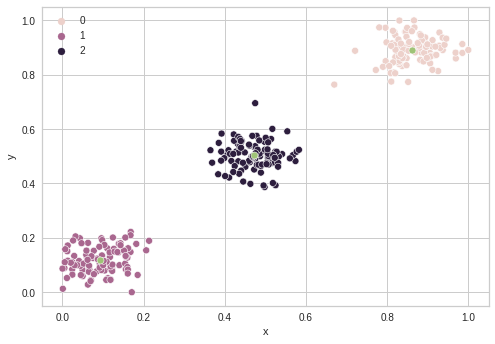

In [ ]:
label, C = kmeans(datan, k = 3, distance = "euclidean")
sns.scatterplot(x = "x", y = "y", hue = label, data = datan)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

### fuzzy-means

In [ ]:
def fuzzy_kmeans(X, m=1.1, distance = "euclidean",  num_c=2, iters=10):
    if isinstance(X, pd.DataFrame):
        X = X.values
    n,_ = X.shape
    U = np.random.uniform( size=( num_c, n ) ) 
    U /= np.sum(U, axis=0)
    for ite in range(iters):
        Um = U ** m
        C = np.array([ np.sum(X * u_m.reshape(-1,1), axis=0) for u_m in Um ])
        C /= np.sum( Um, axis=1 ).reshape(-1,1)
        D = np.array( [ cdist(X, [c], distance) for c in C ] )
        U = 1 / sum( [ (D / d) ** (2 / (m-1)) for d in D ] )
    M = np.argmin( D, axis=0 ).reshape(1, -1)[0]
    return C, M

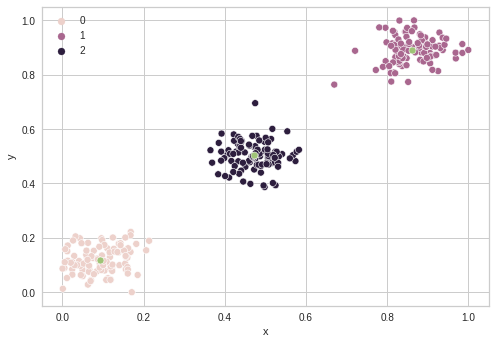

In [ ]:
C, M = fuzzy_kmeans(datan, m=1.1, distance = "euclidean",  num_c=3, iters=100)
sns.scatterplot(x = "x", y = "y", hue = M, data = datan)
sns.scatterplot(x = C[:, 0], y = C[:, 1])


### montain algorithm

In [ ]:
def calculate_membership( X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

def density_function(v, x, param, distance_func):
    return np.exp(-cdist([v], [x], distance_func) ** 2 / (2 * param ** 2))


def mountain_function(X, v, sigma, distance_func):
    return np.sum([density_function(v, x, sigma, distance_func) for x in X])

def update_mountain(V, M, mc, c, sigma, beta, distance_func):
    for i, _ in enumerate(M):
        M[i] -= mc * density_function(V[i], c, beta, distance_func)
    return M

def mountain(X, distance_func = "euclidean", num_c=2, num_div=1, sigma=0.1, beta=0.1):
    if isinstance(X, pd.DataFrame):
        X = X.values
    dimensions = np.linspace(X.max(axis=0), X.min(axis=0), num_div).T
    V = list(product(*dimensions))
    M = [mountain_function(X, v, sigma, distance_func) for v in V]
    C = []
    for i in range(num_c):
        max_pos = np.argmax(M)
        c, mc, =  V[max_pos], M[max_pos]
        M = update_mountain(V, M, mc, c, sigma, beta, distance_func)
        C.append(c)
    M = calculate_membership(X, C, distance_func)
    return np.array(C), M

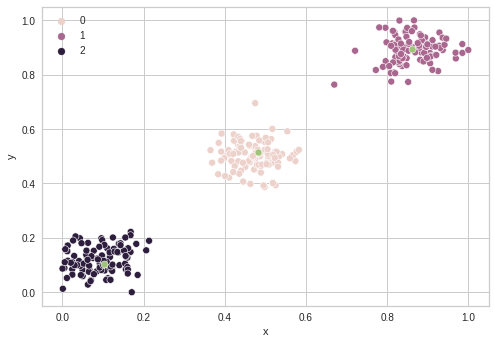

In [ ]:
C, M = mountain(datan, num_c=3, num_div=30)
sns.scatterplot(x = "x", y = "y", hue = M, data = datan)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

### substrative

In [ ]:
def density_function(x, v, denominator, distance_func):
    return np.exp(-distance_func(x, v) ** 2 / denominator)


def substraction_function(X, v, denominator, distance_func):
    return np.sum([density_function(x, v, denominator, distance_func) for x in X])


def calculate_substraction_vector(X, ra, distance_func):
    return [substraction_function(X, x, denominator=(ra / 2) ** 2, distance_func= distance_func) for x in X]


def select_first_center(M, V):
    return V[np.argmax(M)]


def update_substraction(X, M, c, rb, distance_func):
    M_c = np.max(M)
    for i, _ in enumerate(M):
        M[i] -= M_c * density_function(X[i], c, denominator=(rb / 2) ** 2, distance_func=distance_func)
    return M

def calculate_membership( X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

def substract(X, distance_func, num_c=2, num_div=1, ra=6, rb=None):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if not rb:
        rb = 1.5 * ra
    M = calculate_substraction_vector(X, ra, distance_func)
    C = []
    for i in range(num_c):
        c = select_first_center(M, X)
        M = update_substraction(X, M, c, rb, distance_func)
        C.append(c)
    M = calculate_membership(X, C)
    return np.array(C), M

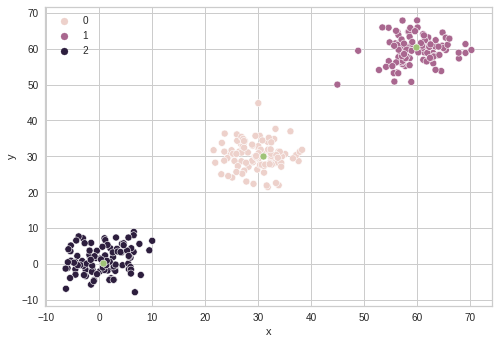

In [ ]:
C, M = substract(data,  euclidean_distance, num_c=3, num_div=400)
sns.scatterplot(x = "x", y = "y", hue = M, data = data)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

## Real Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/omarbecerrasierra/marketing_analysis/main/traindata.csv")
df = df.drop(columns=["Kidhome", "Teenhome", "NumWebVisitsMonth",	"AcceptedCmp3",
                 "AcceptedCmp4",	"AcceptedCmp5",	"AcceptedCmp1",	"AcceptedCmp2",	"Complain",	"Response",
                 "SecondCycle",	"Basic",	"Graduation",	"Master",	"PhD",	"Divorced",	"Married",
                 "Single",	"Together",	"Widow", "AcceptedCmpOverall",
                 "NumDealsPurchases",	"NumWebPurchases",	"NumCatalogPurchases",	"NumStorePurchases", "Recency"])
df = normalization(df)
df

,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Age,Customer_Days,MntTotal,MntRegularProds
0,0.503625,0.425318,0.442211,0.316522,0.664093,0.334601,0.243094,0.696429,0.948498,0.613189,0.628968
1,0.398325,0.007368,0.005025,0.003478,0.007722,0.003802,0.016575,0.750000,0.161660,0.006836,0.108719
2,0.623933,0.285332,0.246231,0.073623,0.428571,0.079848,0.116022,0.553571,0.446352,0.293526,0.355710
3,0.222456,0.007368,0.020101,0.011594,0.038610,0.011407,0.013812,0.214286,0.198856,0.017692,0.118935
4,0.505009,0.115874,0.216080,0.068406,0.177606,0.102662,0.041436,0.267857,0.230329,0.162043,0.246260
...,...,...,...,...,...,...,...,...,...,...,...
2235,0.531169,0.474883,0.216080,0.105507,0.162162,0.448669,0.682320,0.517857,0.545064,0.438279,0.412258
2236,0.556087,0.271936,0.000000,0.017391,0.000000,0.000000,0.022099,0.892857,0.027182,0.173703,0.259394
2237,0.493295,0.608171,0.241206,0.125797,0.123552,0.045627,0.066298,0.267857,0.221745,0.487736,0.538490
2238,0.602791,0.286671,0.150754,0.124058,0.308880,0.114068,0.168508,0.714286,0.223176,0.312827,0.366290


In [ ]:
def find_k(data):
    if isinstance(data, pd.DataFrame):
        data = data.values
    """Find the optimum k clusters"""

    # Use the quick method and immediately show the figure
    kelbow_visualizer(KMeans(),data, k=(2,12))

    return


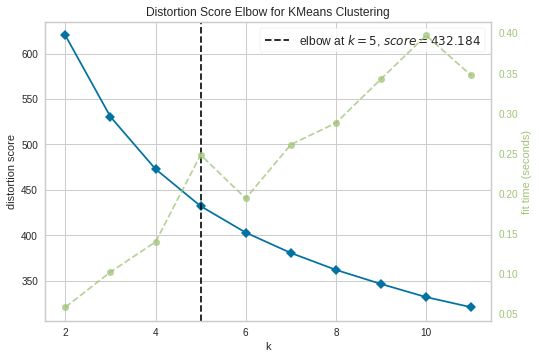

In [ ]:
find_k(df)

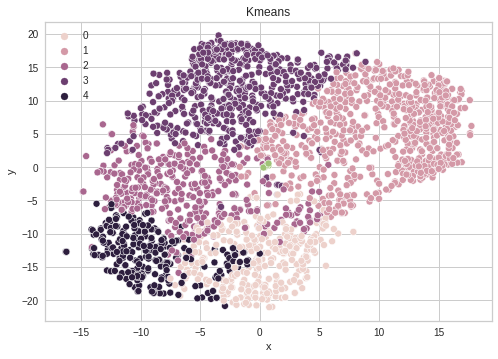

In [ ]:
label_km, C_km = kmeans(df, k = 5, distance = "euclidean")
tsne_em = TSNE(n_components=2, perplexity=150, n_iter=1000).fit_transform(df)
tsne2d = pd.DataFrame(tsne_em, columns = ["x", "y"])
sns.scatterplot(data = tsne2d, x="x", y="y", hue=label_km).set_title("Kmeans")
sns.scatterplot(x = C_km[:, 0], y = C_km[:, 1])

Text(0.5, 1.0, 'Fuzzy Kmeans')

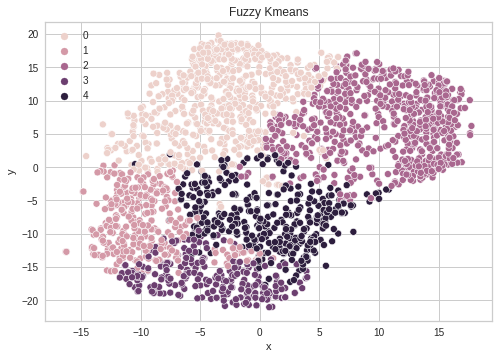

In [ ]:
C_fkm, M_fkm = fuzzy_kmeans(df, m=1.1, distance = "euclidean",  num_c=5, iters=2000)
tsne2d = pd.DataFrame(tsne_em, columns = ["x", "y"])
sns.scatterplot(data = tsne2d, x="x", y="y", hue=M_fkm).set_title("Fuzzy Kmeans")

In [ ]:
def calculate_membership( X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

def density_function_2(v, x, param, distance_func):
    return np.exp(-cdist([v], [x], distance_func) ** 2 / (2 * param ** 2))


def mountain_function(X, v, sigma, distance_func):
    return np.sum([density_function_2(v, x, sigma, distance_func) for x in X])

def update_mountain(V, M, mc, c, sigma, beta, distance_func):
    for i, _ in enumerate(M):
        M[i] -= mc * density_function_2(V[i], c, beta, distance_func)
    return M

def mountain(X, distance_func = "euclidean", num_c=2, num_div=1, sigma=0.1, beta=0.1):
    if isinstance(X, pd.DataFrame):
        X = X.values
    dimensions = np.linspace(X.max(axis=0), X.min(axis=0), num_div).T
    V = list(product(*dimensions))
    M = [mountain_function(X, v, sigma, distance_func) for v in V]
    C = []
    for i in range(num_c):
        max_pos = np.argmax(M)
        c, mc, =  V[max_pos], M[max_pos]
        M = update_mountain(V, M, mc, c, sigma, beta, distance_func)
        C.append(c)
    M = calculate_membership(X, C, distance_func)
    return np.array(C), M

Text(0.5, 1.0, 'Mountain')

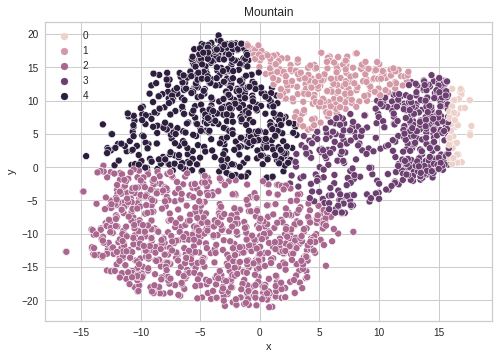

In [ ]:
C_moun, M_moun = mountain(tsne2d, num_c=5, num_div=10)
sns.scatterplot(data = tsne2d, x="x", y="y", hue=M_moun).set_title("Mountain")

In [ ]:
def density_function(x, v, denominator, distance_func):
    return np.exp(-distance_func(x, v) ** 2 / denominator)


def substraction_function(X, v, denominator, distance_func):
    return np.sum([density_function(x, v, denominator, distance_func) for x in X])


def calculate_substraction_vector(X, ra, distance_func):
    return [substraction_function(X, x, denominator=(ra / 2) ** 2, distance_func= distance_func) for x in X]


def select_first_center(M, V):
    return V[np.argmax(M)]


def update_substraction(X, M, c, rb, distance_func):
    M_c = np.max(M)
    for i, _ in enumerate(M):
        M[i] -= M_c * density_function(X[i], c, denominator=(rb / 2) ** 2, distance_func=distance_func)
    return M

def calculate_membership( X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

def substract(X, distance_func, num_c=2, num_div=1, ra=6, rb=None):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if not rb:
        rb = 1.5 * ra
    M = calculate_substraction_vector(X, ra, distance_func)
    C = []
    for i in range(num_c):
        c = select_first_center(M, X)
        M = update_substraction(X, M, c, rb, distance_func)
        C.append(c)
    M = calculate_membership(X, C)
    return np.array(C), M

Text(0.5, 1.0, 'Substrative')

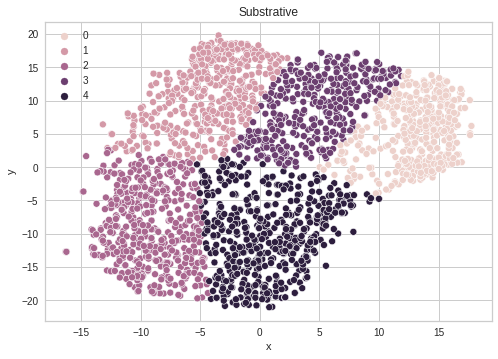

In [ ]:
C_subs, M_subs = substract(tsne2d,  euclidean_distance, num_c=5, num_div=10, ra=6, rb=None)
sns.scatterplot(x = "x", y = "y", hue = M_subs, data = tsne2d).set_title("Substrative")

In [ ]:
tsne = TSNE(n_components=3, n_iter=300, n_jobs = -1, perplexity=150)
tsne_3d = tsne.fit_transform(df)
df_tsne_3d = pd.DataFrame(tsne_3d, columns = ["x", "y", "z"])

Text(0.5, 0.92, 'Fuzzy kmeans')

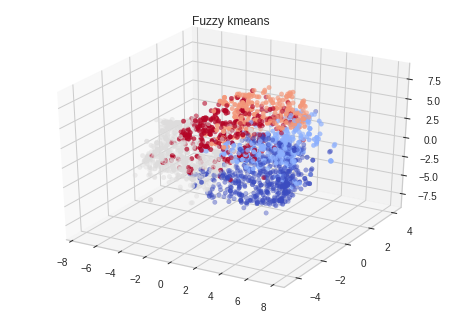

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_tsne_3d.x, df_tsne_3d.y, df_tsne_3d.z, c = M_fkm, cmap = 'coolwarm');
plt.title("Fuzzy kmeans")

Text(0.5, 0.92, 'k-Means')

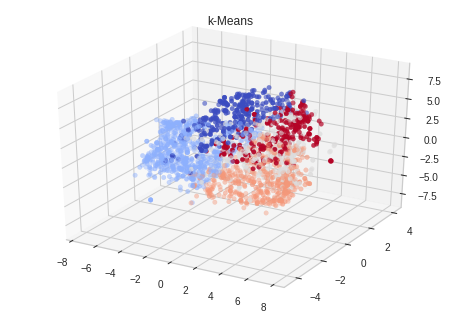

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_tsne_3d.x, df_tsne_3d.y, df_tsne_3d.z, c = label_km, cmap = 'coolwarm');
plt.title("k-Means")

Text(0.5, 0.92, 'Mountain')

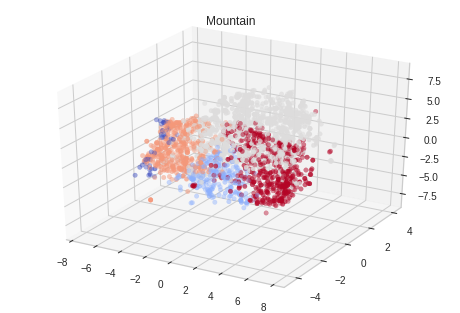

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_tsne_3d.x, df_tsne_3d.y, df_tsne_3d.z, c = M_moun, cmap = 'coolwarm');
plt.title("Mountain")

Text(0.5, 0.92, 'Substrative')

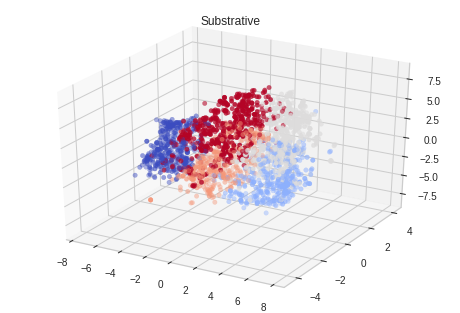

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_tsne_3d.x, df_tsne_3d.y, df_tsne_3d.z, c = M_subs, cmap = 'coolwarm');
plt.title("Substrative")

### UMAP

Text(0.5, 1.0, 'Kmeans')

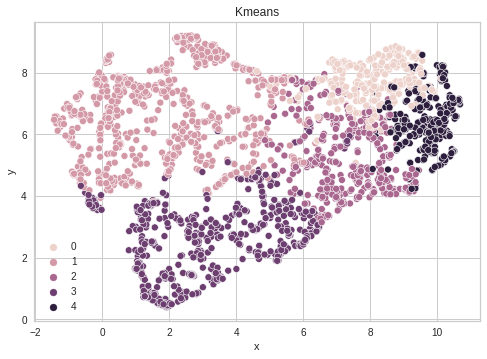

In [ ]:
reducer_umap2d = umap.UMAP(n_components=2, n_jobs=-1)
embedding = reducer_umap2d.fit_transform(df)
umapdf2d = pd.DataFrame(embedding, columns = ["x", "y"])
sns.scatterplot(data = umapdf2d, x="x", y="y", hue=label_km).set_title("Kmeans")

Text(0.5, 1.0, 'Fuzzy Kmeans')

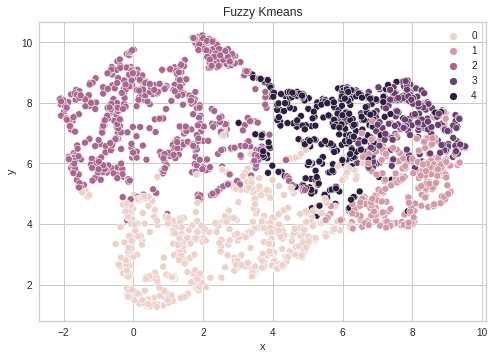

In [ ]:
reducer_umap2d = umap.UMAP(n_components=2, n_jobs=-1)
embedding = reducer_umap2d.fit_transform(df)
umapdf2d = pd.DataFrame(embedding, columns = ["x", "y"])
sns.scatterplot(data = umapdf2d, x="x", y="y", hue=M_fkm).set_title("Fuzzy Kmeans")

Text(0.5, 1.0, 'Mountain')

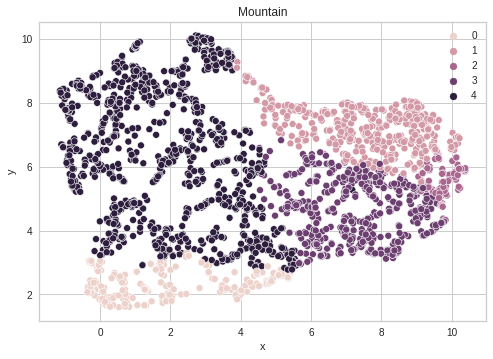

In [ ]:
reducer_umap2d = umap.UMAP(n_components=2, n_jobs=-1)
embedding = reducer_umap2d.fit_transform(df)
umapdf2d = pd.DataFrame(embedding, columns = ["x", "y"])
sns.scatterplot(data = umapdf2d, x="x", y="y", hue=M_moun).set_title("Mountain")

Text(0.5, 1.0, 'Subtrative')

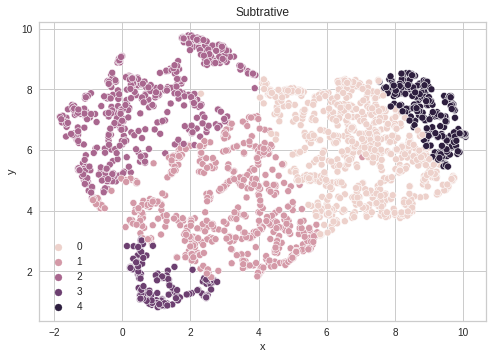

In [ ]:
reducer_umap2d = umap.UMAP(n_components=2, n_jobs=-1)
embedding = reducer_umap2d.fit_transform(df)
umapdf2d = pd.DataFrame(embedding, columns = ["x", "y"])
sns.scatterplot(data = umapdf2d, x="x", y="y", hue=M_subs).set_title("Subtrative")

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



NameError: ignored

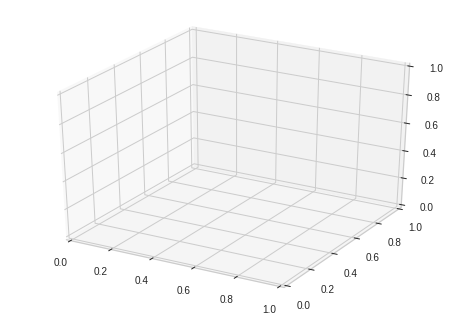

In [ ]:
reducer3d = umap.UMAP(n_components=3, n_jobs = -1)
umap_data_3d= reducer3d.fit_transform(df)
reduced_3d = pd.DataFrame(umap_data_3d, columns = ["x", "y", "z"])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(reduced_3d.x, reduced_3d.y, reduced_3d.z, c = label_km, cmap = 'coolwarm' );
plt.title("Kmeans")

Text(0.5, 0.92, 'Fuzzy-Kemeans')

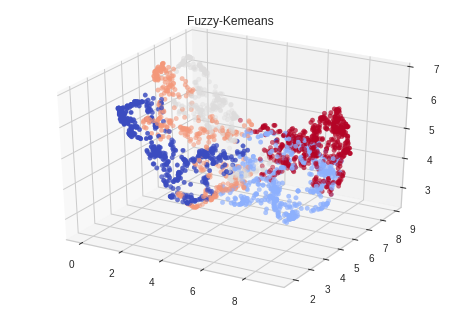

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(reduced_3d.x, reduced_3d.y, reduced_3d.z, c = M_fkm, cmap = 'coolwarm');
plt.title("Fuzzy-Kemeans")

Text(0.5, 0.92, 'Mountain')

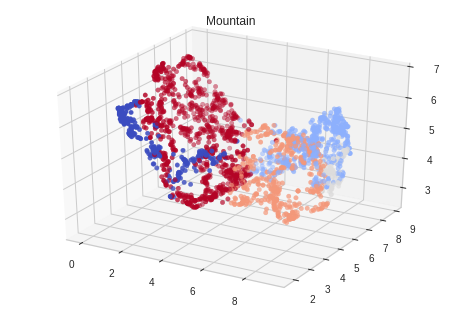

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(reduced_3d.x, reduced_3d.y, reduced_3d.z, c = M_moun, cmap = 'coolwarm');
plt.title("Mountain")

Text(0.5, 0.92, 'Substrative')

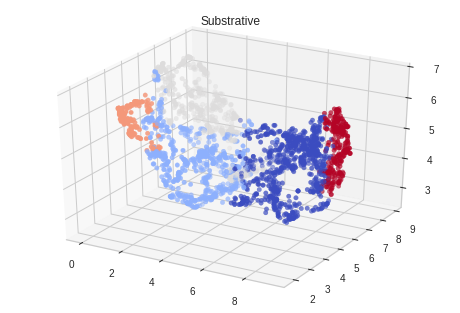

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(reduced_3d.x, reduced_3d.y, reduced_3d.z, c = M_subs, cmap = 'coolwarm');
plt.title("Substrative")

## metrics score

In [ ]:
scores_metric = []
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for i in ["euclidean" , "cityblock", "mahalanobis"]:
    label_km, C_km = kmeans(tsne2d, k = 5, distance = i)
    D = cdist(tsne2d, C_km , i)
    scores_metric.append(["Kmeans", i,   int(sum(sum(D)))])
    C_fkm, M_fkm = fuzzy_kmeans(tsne2d, m=1.1, distance = i,  num_c=5, iters=2000)
    D = cdist(tsne2d, C_fkm , i)
    scores_metric.append(["Fuzzy-Kmeans", i,   int(sum(sum(D)))])
    C_moun, M_moun = mountain(tsne2d, distance_func = i,  num_c=5, num_div=10)
    D = cdist(tsne2d, C_moun, i)
    scores_metric.append(["Mountain", i,   int(sum(sum(D)))])

ValueError: ignored

In [ ]:
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for k, v in metric.items() :
    C_subs, M_subs = substract(tsne2d, distance_func =  v , num_c=5, num_div=10, ra=6, rb=None)
    D = cdist(tsne2d, C_subs , k)
    scores_metric.append(["subtractive", k,   int(sum(sum(D)))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in sqrt



KeyboardInterrupt: ignored

In [ ]:
scores_metric

[['Kmeans', 'euclidean', 176872],
 ['Fuzzy-Kmeans', 'euclidean', 179560],
 ['Mountain', 'euclidean', 203180],
 ['Kmeans', 'cityblock', 229424],
 ['Fuzzy-Kmeans', 'cityblock', 228271],
 ['Mountain', 'cityblock', 261960],
 ['Kmeans', 'mahalanobis', 19314],
 ['Fuzzy-Kmeans', 'mahalanobis', 19183],
 ['subtractive', 'euclidean', 194260],
 ['subtractive', 'cityblock', 257920]]

In [ ]:
print(pd.DataFrame(scores_metric, columns=["Algorithm", "Metric", "Distance"]).to_latex(index=False))

\begin{tabular}{llr}
\toprule
    Algorithm &       Metric &  Distance \\
\midrule
       Kmeans &    euclidean &    176872 \\
 Fuzzy-Kmeans &    euclidean &    179560 \\
     Mountain &    euclidean &    203180 \\
       Kmeans &    cityblock &    229424 \\
 Fuzzy-Kmeans &    cityblock &    228271 \\
     Mountain &    cityblock &    261960 \\
       Kmeans &  mahalanobis &     19314 \\
 Fuzzy-Kmeans &  mahalanobis &     19183 \\
  subtractive &    euclidean &    194260 \\
  subtractive &    cityblock &    257920 \\
\bottomrule
\end{tabular}



In [ ]:
scores_metric_3D = []
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for i in ["euclidean" , "cityblock", "mahalanobis"]:
    label_km, C_km = kmeans(tsne_3d, k = 5, distance = i)
    D = cdist(tsne_3d, C_km , i)
    scores_metric_3D.append(["Kmeans", i,   int(sum(sum(D)))])
    C_fkm, M_fkm = fuzzy_kmeans(tsne_3d, m=1.1, distance = i,  num_c=5, iters=2000)
    D = cdist(tsne_3d, C_fkm , i)
    scores_metric_3D.append(["Fuzzy-Kmeans", i,   int(sum(sum(D)))])
    C_moun, M_moun = mountain(tsne_3d, distance_func = i,  num_c=5, num_div=10)
    D = cdist(tsne_3d, C_moun, i)
    scores_metric_3D.append(["Mountain", i,   int(sum(sum(D)))])

ValueError: ignored

In [ ]:
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for k, v in metric.items() :
    C_subs, M_subs = substract(tsne_3d, distance_func =  v , num_c=5, num_div=10, ra=6, rb=None)
    D = cdist(tsne_3d, C_subs , k)
    scores_metric_3D.append(["subtractive", k,   int(sum(sum(D)))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in sqrt



KeyboardInterrupt: ignored

In [ ]:
print(pd.DataFrame(scores_metric_3D, columns=["Algorithm", "Metric", "Distance"]).to_latex(index=False))

\begin{tabular}{llr}
\toprule
    Algorithm &       Metric &  Distance \\
\midrule
       Kmeans &    euclidean &     72444 \\
 Fuzzy-Kmeans &    euclidean &     72447 \\
     Mountain &    euclidean &     68692 \\
       Kmeans &    cityblock &    104701 \\
 Fuzzy-Kmeans &    cityblock &    103824 \\
     Mountain &    cityblock &    107258 \\
       Kmeans &  mahalanobis &     23308 \\
 Fuzzy-Kmeans &  mahalanobis &     23480 \\
  subtractive &    euclidean &     77548 \\
  subtractive &    cityblock &    110872 \\
\bottomrule
\end{tabular}



# UMAP 

In [ ]:
scores_metric_umap = []
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for i in ["euclidean" , "cityblock", "mahalanobis"]:
    label_km, C_km = kmeans(umapdf2d, k = 5, distance = i)
    D = cdist(umapdf2d, C_km , i)
    scores_metric_umap.append(["Kmeans", i,   int(sum(sum(D)))])
    C_fkm, M_fkm = fuzzy_kmeans(umapdf2d, m=1.1, distance = i,  num_c=5, iters=2000)
    D = cdist(umapdf2d, C_fkm , i)
    scores_metric_umap.append(["Fuzzy-Kmeans", i,   int(sum(sum(D)))])
    C_moun, M_moun = mountain(umapdf2d, distance_func = i,  num_c=5, num_div=10)
    D = cdist(umapdf2d, C_moun, i)
    scores_metric_umap.append(["Mountain", i,   int(sum(sum(D)))])

ValueError: ignored

In [ ]:
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for k, v in metric.items() :
    C_subs, M_subs = substract(umapdf2d, distance_func =  v , num_c=5, num_div=10, ra=6, rb=None)
    D = cdist(umapdf2d, C_subs , k)
    scores_metric_umap.append(["subtractive", k,   int(sum(sum(D)))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning:

invalid value encountered in sqrt



KeyboardInterrupt: ignored

In [ ]:
print(pd.DataFrame(scores_metric_umap, columns=["Algorithm", "Metric", "Distance"]).to_latex(index=False))

\begin{tabular}{llr}
\toprule
    Algorithm &       Metric &  Distance \\
\midrule
       Kmeans &    euclidean &     52636 \\
 Fuzzy-Kmeans &    euclidean &     52635 \\
     Mountain &    euclidean &     59670 \\
       Kmeans &    cityblock &     66316 \\
 Fuzzy-Kmeans &    cityblock &     66274 \\
     Mountain &    cityblock &     77057 \\
       Kmeans &  mahalanobis &     19296 \\
 Fuzzy-Kmeans &  mahalanobis &     19300 \\
  subtractive &    euclidean &     58834 \\
  subtractive &    cityblock &     76669 \\
\bottomrule
\end{tabular}



In [ ]:
scores_metric_3D_umap = []
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance, "mahalanobis" : mahalanobis_distance}
for i in ["euclidean" , "cityblock", "mahalanobis"]:
    label_km, C_km = kmeans(umap_data_3d, k = 5, distance = i)
    D = cdist(umap_data_3d, C_km , i)
    scores_metric_3D_umap.append(["Kmeans", i,   int(sum(sum(D)))])
    C_fkm, M_fkm = fuzzy_kmeans(umap_data_3d, m=1.1, distance = i,  num_c=5, iters=2000)
    D = cdist(umap_data_3d, C_fkm , i)
    scores_metric_3D_umap.append(["Fuzzy-Kmeans", i,   int(sum(sum(D)))])
    C_moun, M_moun = mountain(umap_data_3d, distance_func = i,  num_c=5, num_div=10)
    D = cdist(umap_data_3d, C_moun, i)
    scores_metric_3D_umap.append(["Mountain", i,   int(sum(sum(D)))])

ValueError: ignored

In [ ]:
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance}
for k, v in metric.items() :
    for i in [3, 5, 10 , 15, 20]:
        C_moun, M_moun = mountain(umap_data_3d, distance_func = v,  num_c=5, num_div=i)
        D = cdist(umap_data_3d, C_moun, k)
        print(["Mountain", k,   int(sum(sum(D)))])

['Mountain', 'euclidean', 58975]
['Mountain', 'euclidean', 42606]
['Mountain', 'euclidean', 51218]
['Mountain', 'euclidean', 54497]
['Mountain', 'euclidean', 59573]
['Mountain', 'cityblock', 85179]
['Mountain', 'cityblock', 64225]
['Mountain', 'cityblock', 70783]
['Mountain', 'cityblock', 73724]
['Mountain', 'cityblock', 78485]


In [ ]:
    C_subs, M_subs = substract(umap_data_3d, distance_func =  v , num_c=5, num_div=10, ra=6, rb=None)
    D = cdist(umap_data_3d, C_subs , k)
    scores_metric_3D_umap.append(["subtractive", k,   int(sum(sum(D)))])

In [ ]:

print(pd.DataFrame(scores_metric_3D_umap, columns=["Algorithm", "Metric", "Distance"]).to_latex(index=False))

\begin{tabular}{llr}
\toprule
    Algorithm &       Metric &  Distance \\
\midrule
       Kmeans &    euclidean &     45999 \\
 Fuzzy-Kmeans &    euclidean &     45674 \\
     Mountain &    euclidean &     51218 \\
       Kmeans &    cityblock &     65193 \\
 Fuzzy-Kmeans &    cityblock &     65285 \\
     Mountain &    cityblock &     70783 \\
       Kmeans &  mahalanobis &     23950 \\
 Fuzzy-Kmeans &  mahalanobis &     23949 \\
  subtractive &    euclidean &     52172 \\
  subtractive &    cityblock &     73060 \\
\bottomrule
\end{tabular}



In [ ]:
metric = {"euclidean" : euclidean_distance , "cityblock": manhattan_distance}
for k, v in metric.items():
    for i in [3, 4, 5, 6]:
        for j in [3, 5, 10 , 15, 20]:
            C_subs, M_subs = substract(umap_data_3d, distance_func =  v , num_c=5, num_div=i, ra=j, rb=None)
            D = cdist(umap_data_3d, C_subs, k)
            print(["substractive", k,   int(sum(sum(D)))])

['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
['substractive', 'cityblock', 82388]
['substractive', 'cityblock', 67757]
['substractive', 'cityblock', 57147]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
[

In [ ]:
s = """
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 48695]
['substractive', 'euclidean', 50391]
['substractive', 'euclidean', 39621]
['substractive', 'euclidean', 36780]
['substractive', 'euclidean', 36780]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
['substractive', 'cityblock', 82388]
['substractive', 'cityblock', 67757]
['substractive', 'cityblock', 57147]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
['substractive', 'cityblock', 82388]
['substractive', 'cityblock', 67757]
['substractive', 'cityblock', 57147]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
['substractive', 'cityblock', 82388]
['substractive', 'cityblock', 67757]
['substractive', 'cityblock', 57147]
['substractive', 'cityblock', 73547]
['substractive', 'cityblock', 72265]
['substractive', 'cityblock', 82388]
['substractive', 'cityblock', 67757]
['substractive', 'cityblock', 57147]

"""

In [ ]:
print(s.replace("[", "").replace("]", "\ \\").replace("'", "").replace(",", "&"))


substractive& euclidean& 48695\ \
substractive& euclidean& 50391\ \
substractive& euclidean& 39621\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 48695\ \
substractive& euclidean& 50391\ \
substractive& euclidean& 39621\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 48695\ \
substractive& euclidean& 50391\ \
substractive& euclidean& 39621\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 48695\ \
substractive& euclidean& 50391\ \
substractive& euclidean& 39621\ \
substractive& euclidean& 36780\ \
substractive& euclidean& 36780\ \
substractive& cityblock& 73547\ \
substractive& cityblock& 72265\ \
substractive& cityblock& 82388\ \
substractive& cityblock& 67757\ \
substractive& cityblock& 57147\ \
substractive& cityblock& 73547\ \
substractive& cityblock& 72265\ \
substractive& cityblock& 82388\ \
substractive& cityblock& 67757\ \
substractive&